In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import peartree as pear
import partridge as ptg
import matplotlib.pyplot as plt

In [ ]:
feed = pear.get_representative_feed("gtfs_subway/")

start = 1  
end = 24*60*60 -1 
G = pear.load_feed_as_graph(feed, start, end).to_undirected()

In [ ]:
stops=list(G.nodes())
connectors = list(G.edges)

In [ ]:
stops = [stop[-3:] for stop in stops]
station_data = pd.read_csv("MTA_Subway_Stations.csv")
station_data = station_data[['GTFS Stop ID', 'Complex ID', 'Stop Name', 'Daytime Routes']]

rl = [str(r).split() for r in station_data['Daytime Routes']]
station_data['Daytime Routes'] = rl

In [ ]:
# PostProcessing graph
dn = dict(G.nodes.items())
kl = list(dn.keys())
for k in kl:
	m = k[-3:]
	ls = station_data[station_data['GTFS Stop ID'] == m]
	G.nodes[k]['lines'] = ls.iat[0,3]
	G.nodes[k]['GTFS ID'] = ls.iat[0,0]
	G.nodes[k]['Station Name'] = ls.iat[0,2]
	G.nodes[k]['Complex ID'] = ls.iat[0,1]
	try: del G.nodes[k]['modes']
	except KeyError: continue
nx.relabel_nodes(G, lambda x: x[-3:], copy=False)
G.edges.data()
el = list(dict(G.edges.items()))
for e in el:
	try: del G.edges[e]['mode']
	except KeyError: continue

In [ ]:
# remove Staten Island Railroad

stps = list(dict(G.nodes.items()).keys())
for stp in stps:
	if 'SIR' in G.nodes[stp]['lines']:
		G.remove_node(stp)


In [ ]:
## Add routes to edges
edgelist = G.edges.keys()
for edge in edgelist:
	stop1 = edge[0]
	stop2 = edge[1]
	edge_lines = set(G.nodes[stop1]['lines']).intersection(G.nodes[stop2]['lines'])
	G.edges[edge]['lines'] = edge_lines

G.edges.data()

MultiEdgeDataView([('101', '103', {'length': 120.0, 'lines': {'1'}}), ('103', '104', {'length': 92.57142857142857, 'lines': {'1'}}), ('104', '106', {'length': 90.0, 'lines': {'1'}}), ('106', '107', {'length': 90.0, 'lines': {'1'}}), ('107', '108', {'length': 89.17050691244239, 'lines': {'1'}}), ('108', '109', {'length': 90.0, 'lines': {'1'}}), ('109', '110', {'length': 90.0, 'lines': {'1'}}), ('110', '111', {'length': 90.0, 'lines': {'1'}}), ('111', '112', {'length': 120.0, 'lines': {'1'}}), ('112', '113', {'length': 96.05504587155963, 'lines': {'1'}}), ('113', '114', {'length': 120.0, 'lines': {'1'}}), ('114', '115', {'length': 90.0, 'lines': {'1'}}), ('115', '116', {'length': 101.48648648648648, 'lines': {'1'}}), ('116', '117', {'length': 138.51351351351352, 'lines': {'1'}}), ('117', '118', {'length': 60.0, 'lines': {'1'}}), ('118', '119', {'length': 71.43497757847534, 'lines': {'1'}}), ('119', '120', {'length': 90.0, 'lines': {'1'}}), ('120', '121', {'length': 109.05579399141631, 'l

In [ ]:
S = [s for s in nx.connected_components(G)]
## 5 disconnected components without complexes
## S[0] is the IRT
## S[1] is the 7 train, and possibly express?
## S[2] is the 42 street shuttle
## S[3] is the BMT/IND
## S[4] is the L train
import itertools
def iterator(L):
	a, b = itertools.tee(L)
	next(b, None)
	return list(zip(a,b))

In [ ]:
## transfers in complex
transfers = pd.read_csv('gtfs_subway/transfers.txt')
transfers['lines'] = 0
for i in range(len(transfers['from_stop_id'])):
	coming = transfers['from_stop_id'][i]
	going = transfers['to_stop_id'][i]

	try: 
		d = (G.nodes[coming]['lines'], G.nodes[going]['lines'])
		transfers['lines'][i] = d
	except:
		print(coming, going, i)
		continue

C:\Users\pacma\AppData\Local\Temp\ipykernel_25760\2605484520.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transfers['lines'][i] = d


In [ ]:
transfers.drop("transfer_type", inplace=True, axis=1)
transfers

,from_stop_id,to_stop_id,min_transfer_time,lines
0,101,101,180,"([1], [1])"
1,103,103,180,"([1], [1])"
2,104,104,180,"([1], [1])"
3,106,106,180,"([1], [1])"
4,107,107,180,"([1], [1])"
...,...,...,...,...
611,S01,A45,180,"([S], [C])"
612,S01,S01,180,"([S], [S])"
613,S03,S03,180,"([S], [S])"
614,S04,239,180,"([S], [2, 3, 4, 5])"


In [ ]:
gdf = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
complex_size = dict(gdf['Complex ID'].value_counts())
complex_stns = sorted([k for k, v in complex_size.items() if v>1], reverse=True)
complexed_station_groups = gdf[gdf['Complex ID'].isin(complex_stns)]
grouped = complexed_station_groups.sort_values('Complex ID').groupby('Complex ID', group_keys=True)

for i in complex_stns:
	break
	cpx = grouped.get_group(i)
	cpx_count = len(cpx)
	board_cost = {}
	station_pairs = iterator(cpx.index)
	for pair in station_pairs:
		for stop in pair:
			for line in cpx.loc[stop]['lines']:
				board_cost[line] = cpx.loc[stop]['boarding_cost']
		##print(station_pairs)
		nx.contracted_nodes(G, pair[0], pair[1], self_loops=False, copy=False, store_contraction_as=None)
		nx.relabel_nodes(G, mapping={pair[0]: pair[1]}, copy=False)
		newname = pair[1]
	G.nodes[newname]['boarding_cost'] = board_cost
	G.nodes[newname]['lines'] = list(board_cost.keys())

In [ ]:
C = [s for s in nx.connected_components(G)]
len(C)

##nx.relabel_nodes(G, lambda x: G.nodes[x]['Complex ID'], copy=False)

1

In [ ]:

for st in G.nodes:
	if type(G.nodes[st]['boarding_cost']) is float:
		board_cost = {}
		for line in G.nodes[st]['lines']:
			board_cost[line] = G.nodes[st]['boarding_cost']
		G.nodes[st]['boarding_cost'] = board_cost

In [ ]:
cdf = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
##edf = pd.DataFrame.from_dict(dict(G.edges(data=True)), orient='index')
elist = list(G.edges.data())
edict = {}
for i in range(len(elist)):
	start =elist[i][0]
	stop = elist[i][1]
	data = elist[i][2]
	edict[(start, stop)] = data

cdf

,boarding_cost,y,x,lines,GTFS ID,Station Name,Complex ID
101,{'1': 204.73459715639817},40.889248,-73.898583,[1],101,Van Cortlandt Park-242 St,293
103,{'1': 197.94030742775658},40.884667,-73.900870,[1],103,238 St,294
104,{'1': 197.94030742775658},40.878856,-73.904834,[1],104,231 St,295
106,{'1': 197.4574428118217},40.874561,-73.909831,[1],106,Marble Hill-225 St,296
107,{'1': 194.65328407891528},40.869444,-73.915279,[1],107,215 St,297
...,...,...,...,...,...,...,...
R44,{'R': 290.9320408163265},40.622687,-74.028398,[R],R44,86 St,38
R45,{'R': 290.9320408163265},40.616622,-74.030876,[R],R45,Bay Ridge-95 St,39
S01,{'S': 361.5042366946779},40.680596,-73.955827,[S],S01,Franklin Av,627
S03,{'S': 359.9916666666668},40.674772,-73.957624,[S],S03,Park Pl,141


NetworkXError: Node 293 has no position.

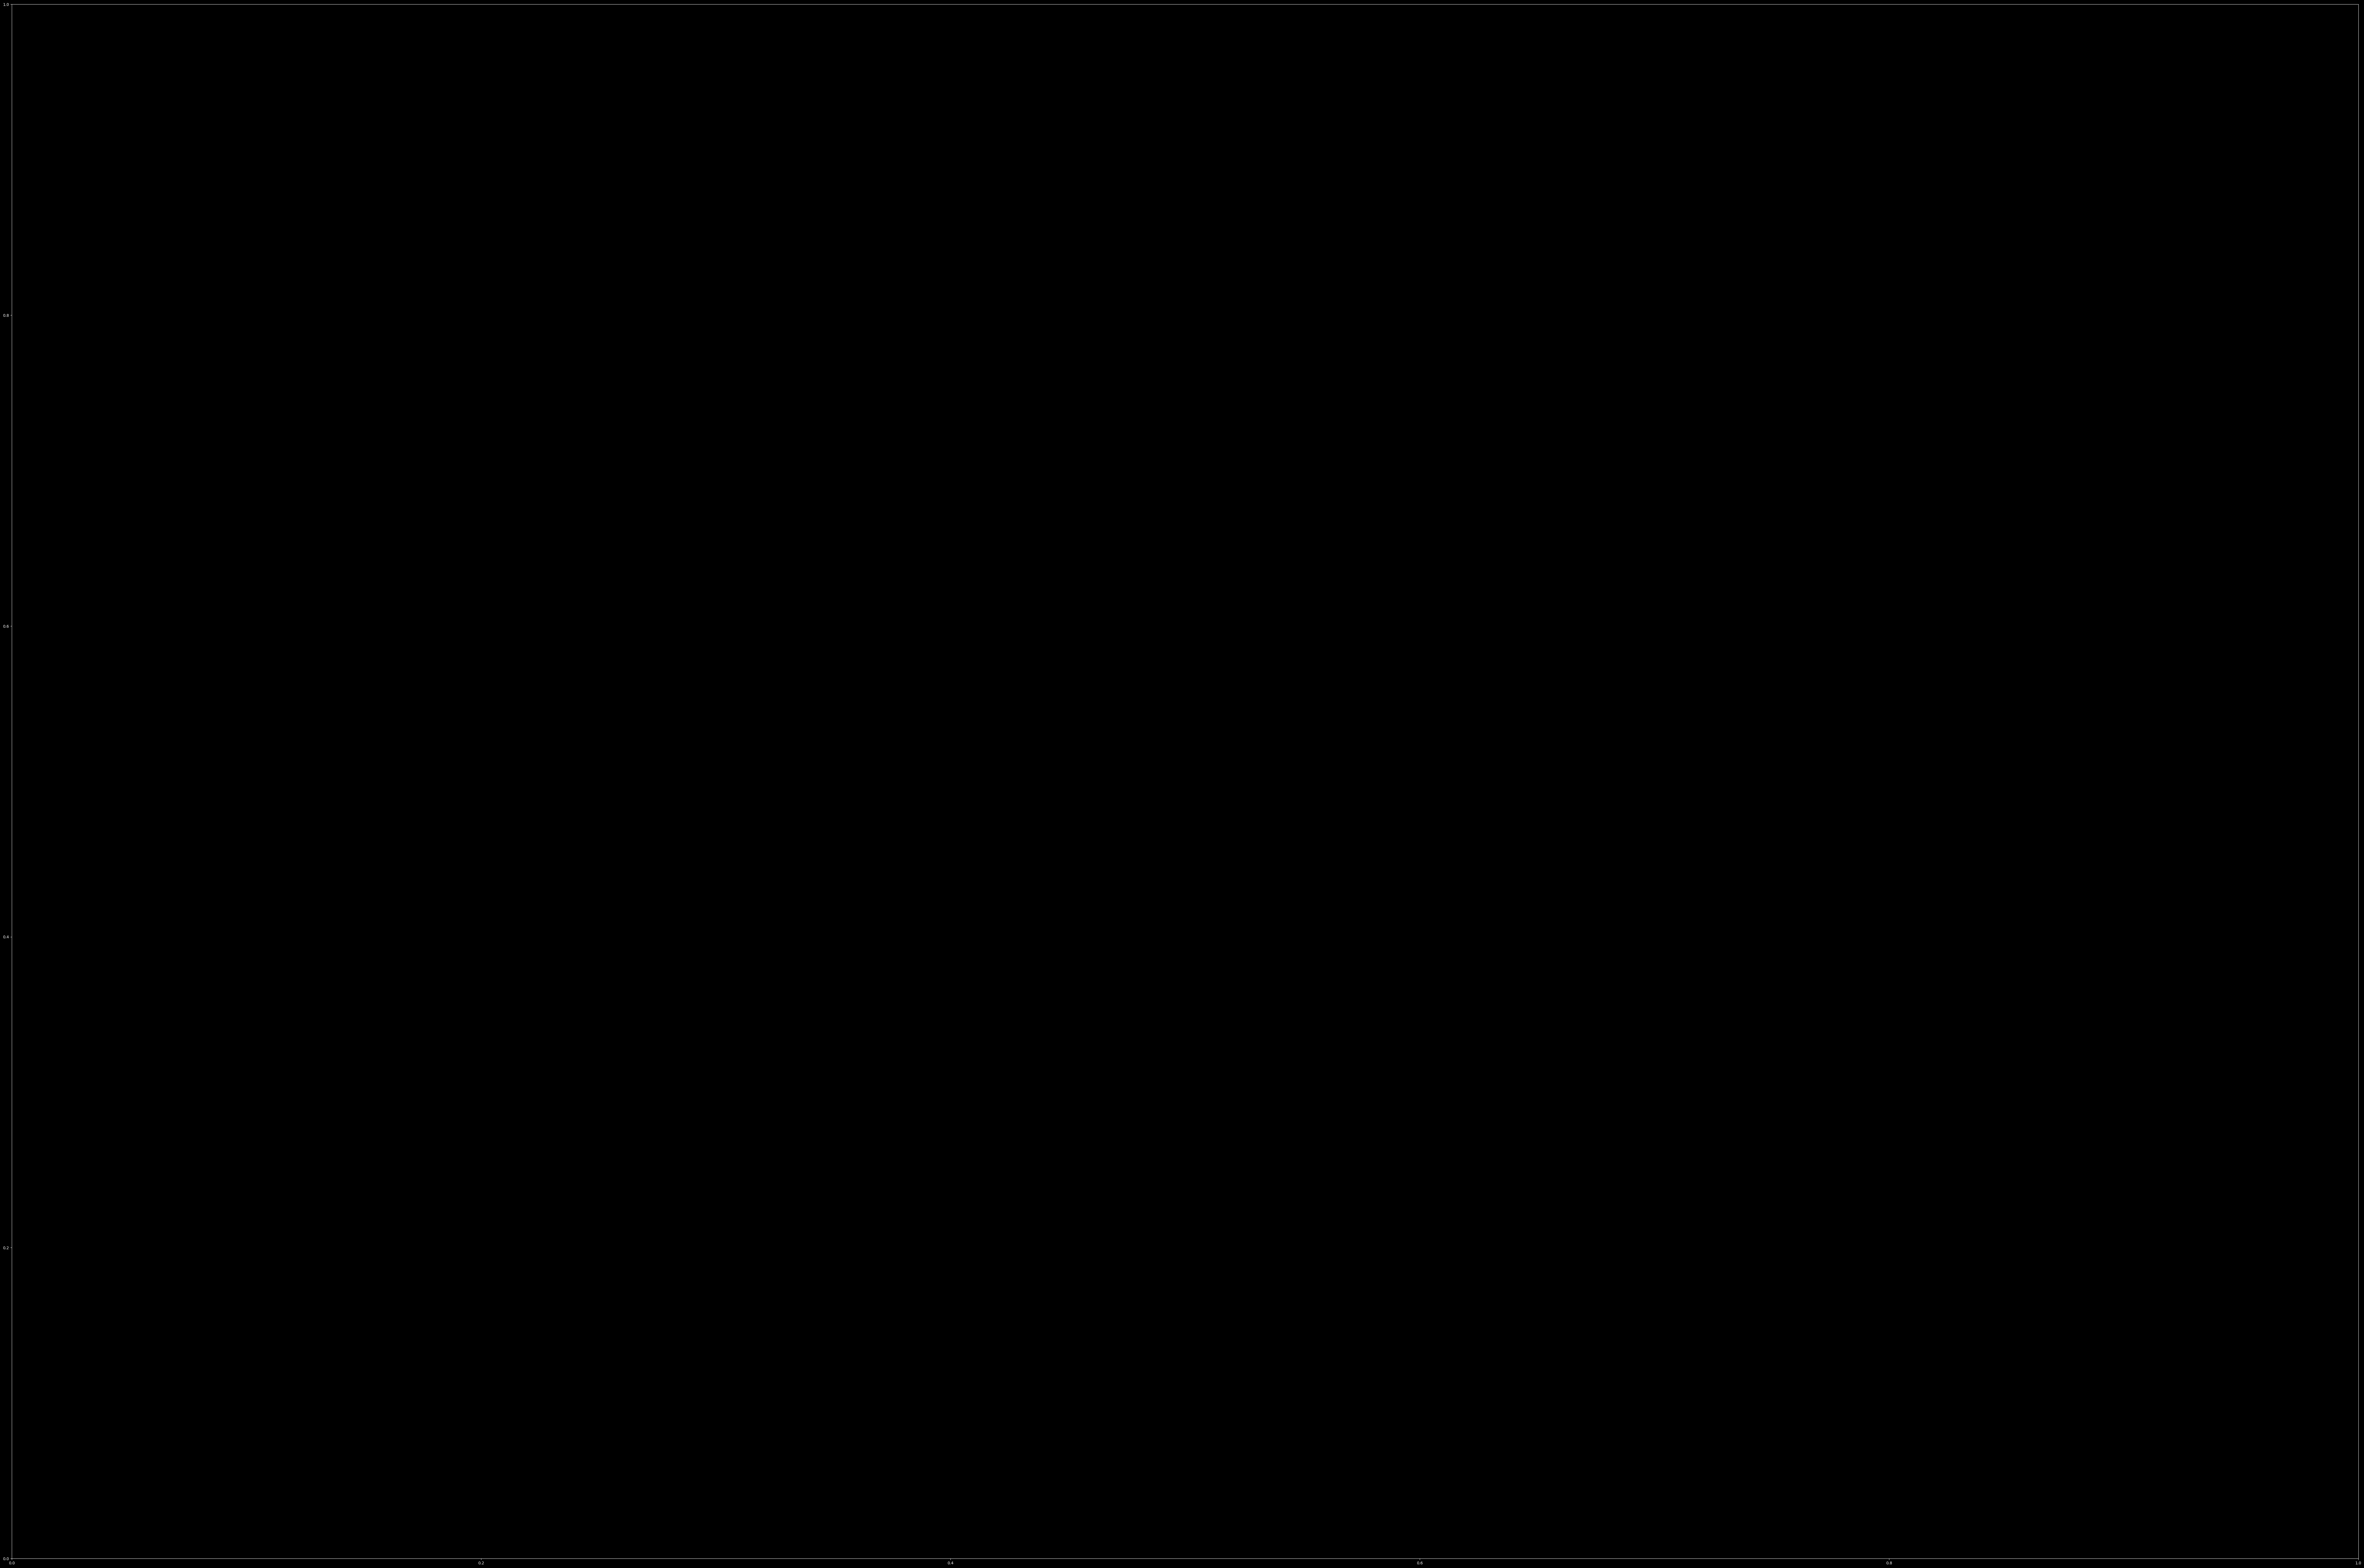

In [ ]:
node_pos = dict(G.nodes.data())
st_pos = pd.DataFrame.from_dict(node_pos).T
st_pos = st_pos[['x','y']].T.to_dict()
coords = [list(list(st_pos.values())[n].values()) for n in range(len(st_pos))]
xylist = np.transpose(coords)
xrange = [min(xylist[0]),max(xylist[0])]
yrange = [min(xylist[1]),max(xylist[1])]
xylist[0] += 74
xylist[1] -= 40
xylist[0]*=10
coords = np.transpose(xylist)
coords = [tuple(i) for i in coords]
coords_rd = []
for x,y in coords:
	coords_rd.append((10*round(x,7), 10*round(y,7)))
coords_rd = dict(zip(G.nodes(), coords_rd))
plt.figure(1, figsize=(108,72))
pos = coords_rd

nx.relabel_nodes(G, lambda x: G.nodes[x]['Complex ID'], copy=False)
nx.draw_networkx(G, with_labels=False, node_size=30, edge_color='w', pos=pos, width=1)



In [ ]:

plt.figure(2, figsize=(30,20))
nx.draw_kamada_kawai(G)
##nx.draw_networkx(G, with_labels=False, node_size=30, edge_color='w' width=1)